# WSI to WSD: соотнесение выделенных кластеров со словарными определениями 

### 1. Переносим сюда данные, с которыми будем работать

In [1]:
import pandas

In [2]:
path = "" # путь до директории, в которой лежат ноутбуки и папки data, preprocessed и results

In [3]:
all_senses_3 = pandas.read_csv(path + "preprocessed\\all_senses_3.csv", "\t", encoding="utf-8")
df_to_work_with = pandas.read_csv(path + "preprocessed\\df_to_work_with.csv", "\t", encoding="utf-8")

In [4]:
# посмотреть на слова в датафрейме и на их набор значений
def analyze_data(df):
    words_dict = dict()

    for target_word in df["word"]:
        if target_word not in words_dict:
            words_dict.setdefault(target_word, set())
    
    # собираем, какие кластеры (значения) есть для каждого целевого слова
    for target_word in words_dict:
        for sense_id in df[df.word == target_word]["gold_sense_id"]:
            words_dict[target_word].add(sense_id)

    # преобразуем set'ы в листы, чтобы был определнённый порядок, и сортируем по возрастанию
    for target_word in words_dict:
        words_dict[target_word] = sorted(list(words_dict[target_word]))

    # смотрим, сколько контекстов на каждое значение
    for target_word in words_dict:
        for i, sense in enumerate(words_dict[target_word]):
            words_dict[target_word][i] = (sense, len(df[df.word == target_word][df.gold_sense_id == sense]))

    return words_dict

In [5]:
all_senses_3_info = analyze_data(all_senses_3)
print(len(all_senses_3_info.keys()))
all_senses_3_info

C:\Users\boss\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


36


{'балка': [(1, 81), (2, 38)],
 'вид': [(1, 38), (2, 3), (5, 36)],
 'винт': [(1, 253), (2, 264), (3, 17), (4, 9), (5, 17)],
 'горн': [(1, 20), (2, 1), (3, 30)],
 'жаба': [(1, 79), (2, 6), (3, 9), (4, 27)],
 'клетка': [(1, 38), (2, 1), (3, 7), (4, 96), (5, 4), (6, 4)],
 'крыло': [(1, 51), (2, 19), (3, 1), (4, 4), (5, 1), (6, 3), (7, 5), (8, 7)],
 'курица': [(1, 62), (2, 31)],
 'лавка': [(1, 92), (2, 147)],
 'лайка': [(1, 81), (2, 18)],
 'мина': [(1, 51), (2, 12), (3, 2)],
 'мишень': [(1, 88), (2, 33)],
 'пост': [(1, 32), (2, 98), (3, 10), (4, 2), (5, 2)],
 'проказа': [(1, 95), (2, 51)],
 'пытка': [(1, 116), (2, 27)],
 'рысь': [(1, 82), (2, 38)],
 'среда': [(1, 13), (2, 32), (3, 47), (4, 52)],
 'хвост': [(1, 100), (3, 8), (4, 12), (7, 1)],
 'штамп': [(1, 45), (2, 1), (3, 3), (4, 47)],
 'замок': [(1, 146), (2, 83)],
 'лук': [(1, 65), (2, 45)],
 'суда': [(1, 100), (2, 35)],
 'бор': [(1, 14), (2, 42)],
 'дисциплина': [(1, 30), (2, 64), (3, 4)],
 'корона': [(1, 48), (2, 23), (3, 7)],
 'кран':

In [6]:
df_to_work_with_info = analyze_data(df_to_work_with)
print(len(df_to_work_with_info.keys()))
df_to_work_with_info

36


C:\Users\boss\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


{'балка': [(1, 81), (2, 38)],
 'вид': [(1, 38), (5, 36)],
 'винт': [(1, 253), (2, 264)],
 'горн': [(1, 20), (3, 30)],
 'жаба': [(1, 79), (4, 27)],
 'клетка': [(1, 38), (4, 96)],
 'крыло': [(1, 51)],
 'курица': [(1, 62), (2, 31)],
 'лавка': [(1, 92), (2, 147)],
 'лайка': [(1, 81)],
 'мина': [(1, 51)],
 'мишень': [(1, 88), (2, 33)],
 'пост': [(1, 32), (2, 98)],
 'проказа': [(1, 95), (2, 51)],
 'пытка': [(1, 116), (2, 27)],
 'рысь': [(1, 82), (2, 38)],
 'среда': [(2, 32), (3, 47), (4, 52)],
 'хвост': [(1, 100)],
 'штамп': [(1, 45), (4, 47)],
 'замок': [(1, 146), (2, 83)],
 'лук': [(1, 65), (2, 45)],
 'суда': [(1, 100), (2, 35)],
 'бор': [(2, 42)],
 'дисциплина': [(1, 30), (2, 64)],
 'корона': [(1, 48)],
 'кран': [(1, 33), (2, 61)],
 'мат': [(4, 50)],
 'отклонение': [(1, 66)],
 'тост': [(1, 73)],
 'билет': [(1, 200), (2, 30)],
 'вешалка': [(1, 325), (2, 36), (3, 112)],
 'вилка': [(1, 311), (5, 57)],
 'галерея': [(6, 67)],
 'горбуша': [(1, 94), (2, 73)],
 'горшок': [(1, 131), (2, 267), (3, 

### 2. Создаём датасеты с определённым процентом ошибок 

In [7]:
import numpy as np

In [8]:
def create_errors_df(df, df_info, all_senses, all_senses_info, percent):
    """
    Возвращает датафрейм, в конец которого для каждого значения добавлены неправильные контексты - 
    контексты из других значений этого слова (вообще всех), у которых gold_sense_id заменено.
    Добавляем столько, чтобы в получившемся датафрейме содержался заданный процент ошибок.
    """
    
    df_to_return = df
    for word in df_info:      
        # df_info[word] - количество контекстов для каждого из значений в переданном датасете, like [(1, 92), (2, 25)]
        
        # сколько неправ. контекстов (из других значений) добавить для каждого из значений, чтобы был заданный процент ошибки
        list_with_num_of_contexts_from_other = []
        for pair in df_info[word]:
            list_with_num_of_contexts_from_other.append((pair[0], round( (pair[1] / (1 - percent)) - pair[1] )))
        
        # теперь в конец df_to_return будем для каждого из значений добавлять опр количество 
        # рандомных строк из других значений (из файла all_senses), заменяя там gold_sense_id
        for i, pair in enumerate(df_info[word]):
            currrent_sense = pair[0]
            num_of_new = list_with_num_of_contexts_from_other[i][1]
            
            # сколько контекстов у всех остальных значений данного слова (смотрим по all_senses)
            num_of_others = sum([pair[1] for pair in all_senses_info[word]]) - df_info[word][i][1]
            
            # если нужно добавить больше контекстов, чем есть в других значениях
            if num_of_new > num_of_others:
                print("Для значения %s слова %s нужно добавить больше контекстов, чем есть во всех остальных его значениях" % 
                     (str(currrent_sense),  word))
                # тогда сначала смотрим, насколько больше (в разы)
                how_many_times = num_of_new // num_of_others
                # выведем слова и их значения, для которых разница слишком большая
                if how_many_times >= 2:
                    print(word, str(currrent_sense))
                
                # датафрейм с контекстами всех остальных значений для данного слова
                other_contexts = all_senses[all_senses.word == word].drop(all_senses[all_senses.word == word]
                                                                          [all_senses.gold_sense_id == currrent_sense].index) 
                # присваиваем им неправльное значение кластера
                other_contexts["gold_sense_id"] = np.array(currrent_sense)
                
                # теперь добавим other_contexts в конец нашего датафрейма how_many_times раз
                for k in range(how_many_times):
                    df_to_return = pandas.concat((df_to_return, other_contexts))
                
                # сколько ещё осталось добавить
                num_of_new = num_of_new - other_contexts.shape[0] * how_many_times

                # вот теперь берём рандомные
                random = other_contexts.sample(num_of_new)
                df_to_return = pandas.concat((df_to_return, random))
                
            else:
                other_contexts = all_senses[all_senses.word == word].drop(all_senses[all_senses.word == word]
                                                                          [all_senses.gold_sense_id == currrent_sense].index)
                # теперь отсюда нужно выбрать num_of_new рандомных строк, заменить в них gold_sense_id на sesne
                # и добавить полученный датафрейм в конец df
                random = other_contexts.sample(num_of_new)
                random["gold_sense_id"] = np.array(currrent_sense)
                df_to_return = pandas.concat((df_to_return, random))
        
    return df_to_return

In [9]:
df_to_work_with.shape

(5400, 7)

In [10]:
df_with_10_errors = create_errors_df(df_to_work_with, df_to_work_with_info, all_senses_3, all_senses_3_info, 0.1)
df_with_10_errors.shape

C:\Users\boss\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(5999, 7)

In [11]:
df_with_20_errors = create_errors_df(df_to_work_with, df_to_work_with_info, all_senses_3, all_senses_3_info, 0.2)
df_with_20_errors.shape

C:\Users\boss\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\boss\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Для значения 1 слова лайка нужно добавить больше контекстов, чем есть во всех остальных его значениях
Для значения 1 слова пытка нужно добавить больше контекстов, чем есть во всех остальных его значениях
Для значения 1 слова хвост нужно добавить больше контекстов, чем есть во всех остальных его значениях
Для значения 1 слова гроза нужно добавить больше контекстов, чем есть во всех остальных его значениях


(6753, 7)

In [12]:
df_with_30_errors = create_errors_df(df_to_work_with, df_to_work_with_info, all_senses_3, all_senses_3_info, 0.3)
df_with_30_errors.shape

C:\Users\boss\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\boss\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Для значения 1 слова лайка нужно добавить больше контекстов, чем есть во всех остальных его значениях
Для значения 1 слова мина нужно добавить больше контекстов, чем есть во всех остальных его значениях
Для значения 1 слова мишень нужно добавить больше контекстов, чем есть во всех остальных его значениях
Для значения 1 слова пытка нужно добавить больше контекстов, чем есть во всех остальных его значениях
Для значения 1 слова хвост нужно добавить больше контекстов, чем есть во всех остальных его значениях
хвост 1
Для значения 1 слова суда нужно добавить больше контекстов, чем есть во всех остальных его значениях
Для значения 2 слова бор нужно добавить больше контекстов, чем есть во всех остальных его значениях
Для значения 4 слова мат нужно добавить больше контекстов, чем есть во всех остальных его значениях
Для значения 1 слова тост нужно добавить больше контекстов, чем есть во всех остальных его значениях
Для значения 1 слова билет нужно добавить больше контекстов, чем есть во всех ос

(7713, 7)

In [13]:
df_with_40_errors = create_errors_df(df_to_work_with, df_to_work_with_info, all_senses_3, all_senses_3_info, 0.4)
df_with_40_errors.shape

Для значения 1 слова балка нужно добавить больше контекстов, чем есть во всех остальных его значениях
Для значения 1 слова жаба нужно добавить больше контекстов, чем есть во всех остальных его значениях
Для значения 4 слова клетка нужно добавить больше контекстов, чем есть во всех остальных его значениях
Для значения 1 слова курица нужно добавить больше контекстов, чем есть во всех остальных его значениях
Для значения 2 слова лавка нужно добавить больше контекстов, чем есть во всех остальных его значениях
Для значения 1 слова лайка нужно добавить больше контекстов, чем есть во всех остальных его значениях
лайка 1
Для значения 1 слова мина нужно добавить больше контекстов, чем есть во всех остальных его значениях
мина 1
Для значения 1 слова мишень нужно добавить больше контекстов, чем есть во всех остальных его значениях
Для значения 2 слова пост нужно добавить больше контекстов, чем есть во всех остальных его значениях

C:\Users\boss\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\boss\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.



Для значения 1 слова проказа нужно добавить больше контекстов, чем есть во всех остальных его значениях
Для значения 1 слова пытка нужно добавить больше контекстов, чем есть во всех остальных его значениях
пытка 1
Для значения 1 слова рысь нужно добавить больше контекстов, чем есть во всех остальных его значениях
Для значения 1 слова хвост нужно добавить больше контекстов, чем есть во всех остальных его значениях
хвост 1
Для значения 1 слова замок нужно добавить больше контекстов, чем есть во всех остальных его значениях
Для значения 1 слова суда нужно добавить больше контекстов, чем есть во всех остальных его значениях
Для значения 2 слова бор нужно добавить больше контекстов, чем есть во всех остальных его значениях
бор 2
Для значения 2 слова дисциплина нужно добавить больше контекстов, чем есть во всех остальных его значениях
Для значения 1 слова корона нужно добавить больше контекстов, чем есть во всех остальных его значениях
Для значения 2 слова кран нужно добавить больше контекс

(8998, 7)

In [15]:
# чтобы потом считывать, не создавать заново
df_with_10_errors.to_csv(path + "preprocessed\\10_errors.csv", "\t", encoding="utf-8", index=False)
df_with_20_errors.to_csv(path + "preprocessed\\20_errors.csv", "\t", encoding="utf-8", index=False)
df_with_30_errors.to_csv(path + "preprocessed\\30_errors.csv", "\t", encoding="utf-8", index=False)
df_with_40_errors.to_csv(path + "preprocessed\\40_errors.csv", "\t", encoding="utf-8", index=False)

In [16]:
df_with_10_errors = pandas.read_csv(path + "preprocessed\\10_errors.csv", "\t", encoding="utf-8")
df_with_20_errors = pandas.read_csv(path + "preprocessed\\20_errors.csv", "\t", encoding="utf-8")
df_with_30_errors = pandas.read_csv(path + "preprocessed\\30_errors.csv", "\t", encoding="utf-8")
df_with_40_errors = pandas.read_csv(path + "preprocessed\\40_errors.csv", "\t", encoding="utf-8")

In [17]:
# и чтобы проверить, правильно работает (да)
df_with_40_errors.to_excel(path + "\\preprocessed\\40_errors.xlsx", index=False)

In [17]:
df_with_10_errors_info = analyze_data(df_with_10_errors)
print(len(df_with_10_errors_info.keys()))
df_with_10_errors_info

36


C:\Users\boss\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


{'балка': [(1, 90), (2, 42)],
 'вид': [(1, 42), (5, 40)],
 'винт': [(1, 281), (2, 293)],
 'горн': [(1, 22), (3, 33)],
 'жаба': [(1, 88), (4, 30)],
 'клетка': [(1, 42), (4, 107)],
 'крыло': [(1, 57)],
 'курица': [(1, 69), (2, 34)],
 'лавка': [(1, 102), (2, 163)],
 'лайка': [(1, 90)],
 'мина': [(1, 57)],
 'мишень': [(1, 98), (2, 37)],
 'пост': [(1, 36), (2, 109)],
 'проказа': [(1, 106), (2, 57)],
 'пытка': [(1, 129), (2, 30)],
 'рысь': [(1, 91), (2, 42)],
 'среда': [(2, 36), (3, 52), (4, 58)],
 'хвост': [(1, 111)],
 'штамп': [(1, 50), (4, 52)],
 'замок': [(1, 162), (2, 92)],
 'лук': [(1, 72), (2, 50)],
 'суда': [(1, 111), (2, 39)],
 'бор': [(2, 47)],
 'дисциплина': [(1, 33), (2, 71)],
 'корона': [(1, 53)],
 'кран': [(1, 37), (2, 68)],
 'мат': [(4, 56)],
 'отклонение': [(1, 73)],
 'тост': [(1, 81)],
 'билет': [(1, 222), (2, 33)],
 'вешалка': [(1, 361), (2, 40), (3, 124)],
 'вилка': [(1, 346), (5, 63)],
 'галерея': [(6, 74)],
 'горбуша': [(1, 104), (2, 81)],
 'горшок': [(1, 146), (2, 297),

In [18]:
df_with_20_errors_info = analyze_data(df_with_20_errors)
df_with_30_errors_info = analyze_data(df_with_30_errors)
df_with_40_errors_info = analyze_data(df_with_40_errors)

C:\Users\boss\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


### 3. Во всех датасетах для каждого значения выделяем ключевые слова

In [19]:
from nltk.probability import FreqDist
import collections
import codecs

In [20]:
def get_words_contexts_dict(df, df_info): 
    """ Получаем словарь {"target_word":{1:"все лем контексты", 2:"все лем контексты"}, "target_word2": ...} """
    dict_to_return = dict()
    for word in df_info:
        senses = [pair[0] for pair in df_info[word]]
        dict_to_return[word] = dict()
        for sense in senses:
            dict_to_return[word][sense] = "\n".join(list(df[df.word == word][df.gold_sense_id == sense]["lem_context"]))
    return dict_to_return

In [21]:
def get_freq_dist(words_contexts_dict): 
    """ Получаем словарь {"target_word":{1:распределение частот слов, 2:распределение}, "target_word2": ...} """
    dist_to_return = dict()
    for word in words_contexts_dict:
        dist_to_return[word] = dict()
        for sense in words_contexts_dict[word]:
            dist_to_return[word][sense] = FreqDist(words_contexts_dict[word][sense].split())
    return dist_to_return

In [22]:
stw_file = path + "my_stopwords.txt"
with codecs.open(stw_file, encoding = 'utf-8') as f:
    stw_set = set(f.read().split())

In [23]:
def get_dist_wo_stopwords(fdist_dict): 
    """ Из распределения частот слов удалим стоп-слова. """
    dist_to_return = dict()
    for target_word in fdist_dict:
        dist_to_return[target_word] = dict()
        for sense in fdist_dict[target_word]:
            dist_to_return[target_word][sense] = dict()
            fdist_for_sense = fdist_dict[target_word][sense]
            for word in fdist_for_sense:
                if word in stw_set: # если слово в списке стоп слов
                    pass
                elif True in set(char in set(list("1234567890")) for char in word): # если в слове содержится цифра
                    pass
                elif True in set(char in set(list("abcdefghijklmnopqrstuvwxyz")) for char in word): # если латинские буквы
                    pass
                else:
                    dist_to_return[target_word][sense][word] = fdist_for_sense[word]
    return dist_to_return

In [24]:
def get_most_frequent_words_per_sense(dist_wo_stopwords, n): 
    """ Получаем словарь, в котором для каждого значения n самых частотных слов. """
    dict_to_return = dict()

    for target_word in dist_wo_stopwords:
        dict_to_return[target_word] = dict()
        for sense in dist_wo_stopwords[target_word]: 
            dict_per_sense = dist_wo_stopwords[target_word][sense]
            sorted_dict_per_sense = collections.OrderedDict(sorted(dict_per_sense.items(), key=lambda kv: kv[1], 
                                                                   reverse=True)[:n])
            dict_to_return[target_word][sense] = sorted_dict_per_sense
    return dict_to_return

In [25]:
# собранные в одну функцию этапы получения ключевых слов (пока всех)
def get_all_key_words(df, df_info, how_many=30):
    words_contexts_dict = get_words_contexts_dict(df, df_info)
    freq_dist_dict = get_freq_dist(words_contexts_dict)
    freq_dist_wo_stopwords = get_dist_wo_stopwords(freq_dist_dict)
    most_frequent = get_most_frequent_words_per_sense(freq_dist_wo_stopwords, n=how_many)
    return most_frequent

Пробовала с 10, 20 и 30 частотными словами, в результате с 30ю результаты самые хорошие.

In [26]:
most_frequent_words = get_all_key_words(df_to_work_with, df_to_work_with_info)

C:\Users\boss\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [28]:
most_frequent_words

{'балка': {1: OrderedDict([('балка', 92),
               ('конец', 12),
               ('деревянный', 12),
               ('стена', 10),
               ('потолок', 10),
               ('дом', 7),
               ('крыша', 7),
               ('здание', 6),
               ('случай', 5),
               ('потолочный', 4),
               ('задний', 4),
               ('машина', 4),
               ('небо', 4),
               ('увидеть', 4),
               ('железный', 4),
               ('место', 4),
               ('колонна', 4),
               ('добавить', 4),
               ('второе', 4),
               ('год', 4),
               ('делать', 4),
               ('висеть', 4),
               ('верёвка', 4),
               ('комната', 3),
               ('поперечный', 3),
               ('работа', 3),
               ('тяжёлый', 3),
               ('дело', 3),
               ('труба', 3),
               ('директор', 3)]),
  2: OrderedDict([('балка', 41),
               ('лежалый', 4),
         

In [27]:
most_frequent_10_errors = get_all_key_words(df_with_10_errors, df_with_10_errors_info)
most_frequent_20_errors = get_all_key_words(df_with_20_errors, df_with_20_errors_info)
most_frequent_30_errors = get_all_key_words(df_with_30_errors, df_with_30_errors_info)
most_frequent_40_errors = get_all_key_words(df_with_40_errors, df_with_40_errors_info)

C:\Users\boss\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


### 4. Из ключевых слов оставляем только хорошие по косинусу 

In [28]:
import zipfile
import gensim
from sklearn.metrics.pairwise import cosine_similarity as cos
import pymorphy2
import copy
morph = pymorphy2.MorphAnalyzer()

C:\Users\boss\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [29]:
# загружаем файл с w2v моделью
model_file = path + "182.zip"
with zipfile.ZipFile(model_file, 'r') as archive:
    stream = archive.open('model.bin')
    model_skipgram = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)

In [30]:
def get_dict_with_words_per_sense(dict_with_word_frequencies):
    """ Получаем словарь {"target_word":{1:"все ключевые слова", 2:"все ключевые слова"}, "target_word2": ...},
        потому что сейчас там OrderedDict. """
    dict_to_return = dict()
    for target_word in dict_with_word_frequencies:
        dict_to_return[target_word] = dict()
        for sense in dict_with_word_frequencies[target_word]:
            ordered_dict = dict_with_word_frequencies[target_word][sense]
            dict_to_return[target_word][sense] = [word for word in ordered_dict]
    
    return dict_to_return

Будем присваивать ЧР теги, чтобы передавать в W2V модель. Используем PyMorphy2, теги которого преобразовывем в Universal Tags, а не обученную UDPipe модель, которую предлагают Кутузов и Кузьменко, потому что в её разметке много ошибок.

In [51]:
def return_modified_pymorphy_pos(word):
    """ Заменять Pymorphy теги ЧР на Universal Tags. """
    p = morph.parse(word)[0]
    if "INFN" in p.tag:
        pos = "VERB"
    elif "ADJF" in p.tag or "ADJS" in p.tag:
        pos = "ADJ"
    elif "ADVB" in p.tag:
        pos = "ADV"
    else:
        pos = str(p.tag.POS)
    return word + "_" + pos # ! не p.normal_form, потому что это уже нормализованные тексты

In [32]:
def get_dict_with_modified_pymorphy_pos(dict_with_words_per_sense):
    """ Возвращает такой же словарь, как dict_with_words_per_sense, но слова теперь с ЧР тегами. """
    dict_to_retrun = dict()

    for target_word in dict_with_words_per_sense:
        dict_to_retrun[target_word+"_NOUN"] = dict()
        for sense in dict_with_words_per_sense[target_word]:
            list_with_pos = []
            list_of_words_without_target = dict_with_words_per_sense[target_word][sense][1:] # потому что первое слово - целевое
            for word in list_of_words_without_target:
                list_with_pos.append(return_modified_pymorphy_pos(word))
            dict_to_retrun[target_word+"_NOUN"][sense] = list_with_pos
    return dict_to_retrun

In [33]:
class GoodWord(object):
    """
    Класс для набора хороших ключевых слов для определённого значения.
    Хорошие - у которых косинус с целевым словом (self.cosine) больше определённого порога. Также тут хранится 
    найденный для  них w2v вектор, который потом будет нужен для вычисления среднего вектора хороших ключевых слов.
    """
    def __init__(self, lemma, pos_word, vec, cosine):
        self.lemma = lemma
        self.pos_word = pos_word
        self.vec = vec
        self.cosine = cosine
    
    def __repr__(self):
        return self.lemma

In [34]:
def get_dict_with_good_words(dict_with_enhanced_pymorphy_pos, threshold=0.3):
    """ Словарь, в котором для каждого слова, ждч каждого его значения (кластера) - список инстансов GoodWord. """

    # важно, что в UDPipe и основанной на ней модели W2V нет слов с "ё", поэтому здесь
    # при получении векторов делаем replace, но сами слова оставляем с "ё"
    dict_to_return = dict()

    for target_word in dict_with_enhanced_pymorphy_pos:
        dict_to_return[target_word] = dict()
        try:
            target_vector = model_skipgram[target_word].reshape(1,300)
        except KeyError: # такого слова нет в словаре
            # так как мы просто добавляли к target_word тег NOUN, теперь можем  попробовать нормализовать слово
            normalized = morph.parse(target_word[:target_word.index("_")])[0].normal_form
            target_vector = model_skipgram[normalized.replace("ё", "е") + "_NOUN"].reshape(1,300)
            
        for sense in dict_with_enhanced_pymorphy_pos[target_word]:
            good_list = []
            for word in dict_with_enhanced_pymorphy_pos[target_word][sense]:
                try:
                    word_vector = model_skipgram[word.replace("ё", "е")].reshape(1,300)
                    c = cos(target_vector,word_vector).tolist()[0][0]
                except KeyError:
                    c = 0
                    # print(word) - выводить те, которых не оказалось в модели W2V
                if c >= threshold:
                    good_list.append(GoodWord(lemma=word[:word.index("_")], pos_word=word, 
                                              vec=word_vector, cosine=round(c, 3)))
                    
            dict_to_return[target_word][sense] = good_list
    return dict_to_return

In [35]:
def sort_dict_with_good_words(dict_with_good_words): 
    """ Сортируем хорошие слова (инстансы GoodWord) в переданном словаре по убыванию косинуса. """
    dict_to_return = copy.deepcopy(dict_with_good_words) # глубокая копия, иначе dict_with_good_words сам изменяется
    for target_word in dict_to_return:
        for sense in dict_to_return[target_word]:
            list_for_sense = dict_to_return[target_word][sense]
            sorted_list_for_sense = sorted(list_for_sense, key=lambda element: element.cosine, reverse = True)
            dict_to_return[target_word][sense] = sorted_list_for_sense
    return dict_to_return

In [36]:
# собранные вместе этапы получения словаря с хорошими ключевыми словами
def get_sorted_good_words_from_key_words(key_words):
    kw_per_sense = get_dict_with_words_per_sense(key_words) # для значения оставляем только сами ключевые слова
    pos_dict = get_dict_with_modified_pymorphy_pos(kw_per_sense) # присваиваем им ЧР
    good_kw_words_per_sense = get_dict_with_good_words(pos_dict) # получаем инстансы GoodWords (print - если слова нет в W2V)
    sorted_good_kw_words_per_sense = sort_dict_with_good_words(good_kw_words_per_sense) # сортируем по значению косинуса
    return sorted_good_kw_words_per_sense

In [37]:
words_for_perfect = get_sorted_good_words_from_key_words(most_frequent_words)

In [38]:
words_for_perfect = get_sorted_good_words_from_key_words(most_frequent_words)
words_for_10_errors = get_sorted_good_words_from_key_words(most_frequent_10_errors)
words_for_20_errors = get_sorted_good_words_from_key_words(most_frequent_20_errors)
words_for_30_errors = get_sorted_good_words_from_key_words(most_frequent_30_errors)
words_for_40_errors = get_sorted_good_words_from_key_words(most_frequent_40_errors)

In [39]:
words_for_perfect

{'балка_NOUN': {1: [поперечный,
   крыша,
   потолочный,
   верёвка,
   труба,
   деревянный,
   колонна,
   стена,
   потолок,
   задний,
   висеть],
  2: [склон,
   станица,
   гора,
   степь,
   кустарник,
   камень,
   спускаться,
   сухой,
   берег,
   леса]},
 'вид_NOUN': {1: [сторона, глаз, придавать, следующий],
  5: [человек,
   место,
   свойственный,
   сказать,
   большой,
   дух,
   отличаться,
   результат]},
 'винт_NOUN': {1: [болт,
   гайка,
   пружина,
   регулировочный,
   ручка,
   крепление,
   отверстие,
   крышка,
   крепиться,
   головка,
   панель,
   регулировка,
   диаметр,
   резьба,
   конструкция,
   деталь],
  2: [лопасть,
   мотор,
   двигатель,
   несущий,
   вращение,
   гребной,
   вращаться,
   диаметр,
   самолёт,
   вертолёт,
   корабль,
   лодка,
   машина,
   скорость,
   вода,
   мощность,
   воздух,
   полёт]},
 'горн_NOUN': {1: [наковальня,
   кузница,
   пламя,
   кузнечный,
   чугун,
   уголь,
   кузня,
   огонь,
   печь,
   сталь,
   гудеть,

In [41]:
def write_kw_to_file(kw, file_name):
    with codecs.open(path + "results\\%s.txt" % file_name, "w", "utf-8") as file:
        for key in kw:
            file.write("------------------- %s -------------------\n" % key)
            for sense in kw[key]:
                file.write("##### %s #####\n" % sense)
                list_of_good_lemmas = [instance.lemma for instance in kw[key][sense]]
                file.write(" ".join(list_of_good_lemmas))
                file.write("\n")
            file.write("\n")

In [42]:
write_kw_to_file(words_for_perfect, "kw_for_0_errors")

Посмотрим, насколько хорошо выделяются КС. Есть значения, для которых КС вообще не выделились или выделилось недостаточно:

* мишень#2: 'стрела' 
    (*2. перен. Тот, кто является предметом насмешек, нападок, преследования.*)  
* пост#1: 'начальник' 
    (*1. Место, откуда наблюдают за кем-либо, чем-либо; пункт, который охраняют. || Любое место, с которого наблюдают за чем-либо. 2. Постоянный пункт охраны (на границе, линии обороны и т.п.); застава, кордон. 4. Лицо или группа лиц, поставленных в определенном месте для охранения кого-либо, чего-либо, наблюдения за кем-либо, чем-либо.*)
* пытка#2: ' ' 
    (*2. перен. Сильное нравственное страдание; мучение, терзание.*)
* среда#3: ' ' 
    (*3. Окружение, социально-бытовые условия, в которых протекает жизнь человека. || Совокупность людей, связанных общностью жизненных условий, занятий, интересов.*)

In [43]:
write_kw_to_file(words_for_10_errors, "kw_for_10_errors")
write_kw_to_file(words_for_20_errors, "kw_for_20_errors")
write_kw_to_file(words_for_30_errors, "kw_for_30_errors")
write_kw_to_file(words_for_40_errors, "kw_for_40_errors")

### 5. Создание словаря с определениями слов через подключение к онлайн-словарю

In [40]:
from urllib.parse import quote
import requests
from bs4 import BeautifulSoup
import time

In [41]:
words = list(df_to_work_with_info.keys())
words

['балка',
 'вид',
 'винт',
 'горн',
 'жаба',
 'клетка',
 'крыло',
 'курица',
 'лавка',
 'лайка',
 'мина',
 'мишень',
 'пост',
 'проказа',
 'пытка',
 'рысь',
 'среда',
 'хвост',
 'штамп',
 'замок',
 'лук',
 'суда',
 'бор',
 'дисциплина',
 'корона',
 'кран',
 'мат',
 'отклонение',
 'тост',
 'билет',
 'вешалка',
 'вилка',
 'галерея',
 'горбуша',
 'горшок',
 'гроза']

In [42]:
dict_to_use = "https://gufo.me/dict/efremova/" 
roman = {"I", "V", "X"} # обозначение значения начинается с романских цифр

# в названии значения для данных ЧР должны содержаться приведённые строки
dict_look_at_POS = {"NOUN": {" ср.", " м.", " ж.", " мн."}, "VERB": {" несов.", " сов."}, 
                "ADJ": {" прил."}, "ADV": {" нареч."}}

def get_definitions(words, common_dict=dict(), look_at_lemmas_not_words=True, look_at_POS="ALL"):
    """
    words - список слов;
    common_dict - словарь, куда будем записывать результат (мб пустым или уже содержать что-то);
    look_at_lemmas_not_words - искать вхождения в словаре только по переданным словам as is или по всем их возможным леммам;
    look_at = {"ALL", "NOUN", "VERB", "ADJ", "ADV"} - определения каких ЧР включать в словарь.
    
    Возвращает словарь с текстом определений: {key: {sense_name: ["опр1", "опр2"], sense_name2: ["опр1"]}, key2: {...}}
    В качестве ключей - либо все возможные леммы для переданных слов, либо сами слова в таком виде, как они передаются
    (в зависимости от look_at_lemmas_not_words).
    """
    
    for word in words:
        
        if look_at_lemmas_not_words: # тогда итерация по возможным леммам переданных слов, а не по самим словам
            variants = morph.parse(word)
            set_of_lemmas = set([el.normal_form for el in variants]) # все возможные леммы для слова

            for lemma in set_of_lemmas:
                if lemma not in common_dict:
                    dict_with_senses = dict()
                    encoded_word = quote(lemma)
                    content = requests.get(dict_to_use + encoded_word).text
                    soup = BeautifulSoup(content, 'html.parser')
                    text = [el.get_text() for el in soup.find_all('p')[:-1]] # список строк, отделённых в определении абзацем
                    if text == ['Слово не найдено (в индексе и в фейловере).']:
                        print("Лемма '%s' слова '%s' не найдена в словаре" % (lemma, word))
                        continue
                    else:
                        if text[0] == "1.": # это исключения, когда есть ещё один, более внешний уровень разделения значений:
                            # на имя нарицательное и имя собственное (напр., у "рысь"). Нас интересует только нарицательное.
                            print("Имя собственное есть у леммы '%s' (слово '%s')" % (lemma, word))
                            text = text[1:text.index("2.")]

                        text_all = " ".join(text)
                        if ("I" in text_all) and ("II" in text_all): # если есть явно разграничиваемые значения
                            for element in text[1:]: # первый элемент здесь - просто само слово
                                el_is_key = False
                                for digit in roman:
                                    if digit == element[0]: # тогда этот элемент (строка) будет ключом словаря
                                        el_is_key = True
                                        key = element
                                        dict_with_senses[key] = []
                                        break
                                if el_is_key:
                                    continue
                                else:
                                    if not element.startswith("||"): # это самостоятельное определение, добавляем его 
                                        dict_with_senses[key].append(element)
                                    else: # это оттенок значения, мы добавляем эту строку в конец предыдущего определения
                                        # continue - если вообще игнорируем оттенки значений
                                        num_of_last_el = len(dict_with_senses[key]) - 1
                                        dict_with_senses[key][num_of_last_el] = dict_with_senses[key][num_of_last_el] + \
                                                                                " " + element
                        else:
                            try:
                                dict_with_senses[text[0]] = [] # ключом будет слово + род, типа "путь м."
                            except IndexError: # возникали какие-то ошибки, если запрашивать сразу много слов, без time.sleep()
                                print(text)
                                raise IndexError("Проблема с леммой '%s' слова '%s'" % (lemma, word))
                            for element in text[1:]:
                                if not element.startswith("||"):
                                    dict_with_senses[text[0]].append(element)
                                else:
                                    num_of_last_el = len(dict_with_senses[text[0]]) - 1
                                    dict_with_senses[text[0]][num_of_last_el] = dict_with_senses[text[0]][num_of_last_el] + \
                                                                                " " + element

                    common_dict[lemma] = dict_with_senses
                    time.sleep(0.5)  # без этого не получается обработать подряд все слова, возникает ошибка
                    
                    
        else: # почти всё то же самое, но смотрим на сами слова
            if word not in common_dict:
                dict_with_senses = dict()
                encoded_word = quote(word)
                content = requests.get(dict_to_use + encoded_word).text
                soup = BeautifulSoup(content, 'html.parser')
                text = [el.get_text() for el in soup.find_all('p')[:-1]] # последний элемент - "© 2019 Gufo.me"

                if text == ['Слово не найдено (в индексе и в фейловере).']: # переходим к следующему слову
                    print("Слово '%s' не найдено в словаре" % word)
                    continue 

                if text[0] == "1.": # это исключения - см выше
                    print("Имя собственное есть у слова '%s'" % word)
                    text = text[1:text.index("2.")]

                text_all = " ".join(text)
                if ("I" in text_all) and ("II" in text_all): # если есть явно разграничиваемые значения
                    for element in text[1:]: # первый элемент здесь - просто само слово
                        el_is_key = False
                        for digit in roman:
                            if digit == element[0]: # тогда это будет ключом словаря
                                el_is_key = True
                                key = element
                                dict_with_senses[key] = []
                                break
                        if el_is_key:
                            continue
                        else:
                            if not element.startswith("||"):
                                dict_with_senses[key].append(element)
                            else: # оттенки значений, идущие после ||, присоединяем к предыдущему определению
                                num_of_last_el = len(dict_with_senses[key]) - 1
                                dict_with_senses[key][num_of_last_el] = dict_with_senses[key][num_of_last_el] + " " + element
                else:
                    try:
                        dict_with_senses[text[0]] = [] # ключом будет слово + род, like "путь м."
                    except IndexError: # возникали какие-то ошибки, если запрашивать сразу много слов, без time.sleep()
                        print(text)
                        raise IndexError("Проблема со словом " + word)
                    for element in text[1:]:
                        if not element.startswith("||"):
                            dict_with_senses[text[0]].append(element)
                        else:
                            num_of_last_el = len(dict_with_senses[text[0]]) - 1
                            dict_with_senses[text[0]][num_of_last_el] = dict_with_senses[text[0]][num_of_last_el] + \
                                                                        " " + element
                common_dict[word] = dict_with_senses
                time.sleep(0.5)  # без этого не сделать подряд все слова, возникает ошибка и нужно разбивать на части
    
    # теперь оставим в словаре только определения тех ЧР, которые нам нужны
    if not look_at_POS == "ALL":
        pairs_key_key_to_delete = []
        for word in common_dict:
            for sense_name in common_dict[word]:
                if not any([element in sense_name for element in dict_look_at_POS[look_at_POS]]): 
                    # если в названии значения нет указания на нужную нам ЧР
                    pairs_key_key_to_delete.append((word, sense_name))
        if pairs_key_key_to_delete:
            for pair in pairs_key_key_to_delete:
                del common_dict[pair[0]][pair[1]]
    
    return common_dict

In [43]:
start = time.time()
dict_with_lemmas = get_definitions(words)
print(time.time()-start)
dict_with_lemmas

Лемма 'лайк' слова 'лайка' не найдена в словаре
Имя собственное есть у леммы 'рысь' (слово 'рысь')
24.992429494857788


{'балка': {'I ж.': ['Брус, укрепленный горизонтально между двумя стенами или устоями и служащий опорой, поддержкой чего-либо (потолка, моста и т.п.).'],
  'II ж.': ['Длинный и широкий овраг, лощина (обычно с пологими склонами, поросшими растительностью).']},
 'вид': {'I м.': ['1. Внешний облик; внешность, наружность. || Внешний облик, производящий благоприятное впечатление.',
   '2. То, что оказывается перед глазами, в поле зрения. || Открывающаяся взгляду картина окружающей природы, местности.',
   '3. Изображение природы, города и т.п. в рисунке, живописи, графике; пейзаж.'],
  'II м.': ['1. Понятие, обозначающее ряд предметов или явлений с одинаковыми признаками и входящее в более общее понятие рода.',
   '2. Совокупность особей, объединенных по общности признаков, служащая — вместе с более общими понятиями рода (семейства, отряда, класса) — основой классификации животных и растений.',
   '3. Разновидность, тип.'],
  'III м.': ['Грамматическая категория глагола, обозначающая характе

In [44]:
start = time.time()
dict_with_words = get_definitions(words, look_at_lemmas_not_words=False)
print(time.time()-start)
dict_with_words

Слово 'суда' не найдено в словаре
0.11500668525695801


{'балка': {'I ж.': ['Брус, укрепленный горизонтально между двумя стенами или устоями и служащий опорой, поддержкой чего-либо (потолка, моста и т.п.).'],
  'II ж.': ['Длинный и широкий овраг, лощина (обычно с пологими склонами, поросшими растительностью).']},
 'вид': {'I м.': ['1. Внешний облик; внешность, наружность. || Внешний облик, производящий благоприятное впечатление.',
   '2. То, что оказывается перед глазами, в поле зрения. || Открывающаяся взгляду картина окружающей природы, местности.',
   '3. Изображение природы, города и т.п. в рисунке, живописи, графике; пейзаж.'],
  'II м.': ['1. Понятие, обозначающее ряд предметов или явлений с одинаковыми признаками и входящее в более общее понятие рода.',
   '2. Совокупность особей, объединенных по общности признаков, служащая — вместе с более общими понятиями рода (семейства, отряда, класса) — основой классификации животных и растений.',
   '3. Разновидность, тип.'],
  'III м.': ['Грамматическая категория глагола, обозначающая характе

Несколько лемм на входное слово: 
* крыло -- крыло сущ, крыть гл
* замок -- замок сущ, замокнуть гл
* лук ---- лук сущ, лука сущ
* суда --- суд сущ, судно сущ (в словаре, где ключи - слова как они были переданы, этого слова вообще нет, потому что так оно не находится в Ефремовой)
* бор ---- бор сущ, бора сущ
* вилка -- вилка сущ, вилок сущ

Мы будем использовать словарь по леммам.

In [49]:
dict_with_lemmas.keys()

dict_keys(['балка', 'вид', 'винт', 'горн', 'жаба', 'клетка', 'крыть', 'крыло', 'курица', 'лавка', 'лайка', 'мина', 'мишень', 'пост', 'проказа', 'пытка', 'рысь', 'среда', 'хвост', 'штамп', 'замок', 'замокнуть', 'лук', 'лука', 'судно', 'суд', 'бор', 'бора', 'дисциплина', 'корона', 'кран', 'мат', 'отклонение', 'тост', 'билет', 'вешалка', 'вилка', 'вилок', 'галерея', 'горбуша', 'горшок', 'гроза'])

In [50]:
dict_with_words.keys()

dict_keys(['балка', 'вид', 'винт', 'горн', 'жаба', 'клетка', 'крыло', 'курица', 'лавка', 'лайка', 'мина', 'мишень', 'пост', 'проказа', 'пытка', 'рысь', 'среда', 'хвост', 'штамп', 'замок', 'лук', 'бор', 'дисциплина', 'корона', 'кран', 'мат', 'отклонение', 'тост', 'билет', 'вешалка', 'вилка', 'галерея', 'горбуша', 'горшок', 'гроза'])

### 6. Предобработка полученных определений 

In [45]:
from pymorphy2.tokenizers import simple_word_tokenize

In [46]:
class SenseDefinition(object):
    """
    Класс для определений из словаря и дальнейшей работы с ними. На вход передаём только raw строку с самим определением,
    она обрабатывается (два варианта: просто лемматизируется и с ЧР), получаем вектор w2v для этого определения.
    """
    def __init__(self, raw_text):
        self.raw_text = raw_text
        self.normalized, self.normalized_with_pos = normalize_string(raw_text, stw_set)
        self.vec = get_w2v_vec(self.normalized_with_pos)
    
    def __repr__(self):
        return "[%s,\n%s\n%s]" % (self.raw_text, self.normalized, self.normalized_with_pos)

In [47]:
def get_w2v_vec(preprocessed_string):
    list_with_vectors = []
    for word in preprocessed_string.split():
        try:
            vec = model_skipgram[word.replace("ё", "е")].reshape(1,300)
            list_with_vectors.append(vec)
        except KeyError: # если слова нет в модели - ничего не делаем, вектор не участвтует вычислении среднего значения
            print("Слова '%s' нет в модели" % word)
            continue
    if list_with_vectors != []:
        mean_vec = np.mean(list_with_vectors, axis=0)
    else:
        print("У этого определения будет нулевой вектор: " + preprocessed_string) # напр., у значения ['см. замокать']
        mean_vec = np.zeros(300).reshape(1,300)
    return mean_vec

In [48]:
def normalize_string(string_to_normalize, stw_set): 
    """ 
    Возвращает 1) лемматизированную строку без стоп-слов, 2) ту же строку, но с тегами ЧР как в W2V.
    
    string_to_normalize - строка raw текста
    stw_set - множество стоп-слов
    """
        
    # именно для работы со словарём: вручную убираем пометы
    string = string_to_normalize.replace(" разг.", "").replace(" простореч.", "").replace(" перен.", "").replace(" устар.", "")

    lemmatized_list_for_string = [] # лемматизируем
    for token in simple_word_tokenize(string):
        if token == "см": # pymotphy заменяет его на "сантиметр", а так мы просто убираем
            continue
        lemmatized_list_for_string.append(morph.parse(token)[0].normal_form) 

    good_lemmatized_list_for_string = [] # убираем плохие токены    
    for lemmatized_token in lemmatized_list_for_string:
        if lemmatized_token in stw_set: # если слово в списке стоп слов
            pass
        elif True in set(char in set(list("1234567890")) for char in lemmatized_token): # если в слове содержится цифра
            pass
        elif True in set(char in set(list("abcdefghijklmnopqrstuvwxyz")) for char in lemmatized_token): # если латинские буквы
            pass
        else:
            good_lemmatized_list_for_string.append(lemmatized_token)
    
    lemmas_with_pos = []
    for lemma in good_lemmatized_list_for_string:
        lemmas_with_pos.append(return_modified_pymorphy_pos(lemma))
    
    return " ".join(good_lemmatized_list_for_string), " ".join(lemmas_with_pos)

In [50]:
# глубокая копия, иначе dict_with_lemmas сам будем тоже изменяться
dict_with_definition_instances = copy.deepcopy(dict_with_lemmas)

for lemma in dict_with_definition_instances:
    for sense in dict_with_definition_instances[lemma]:
        list_of_strings_to_normalize = dict_with_definition_instances[lemma][sense]
        dict_with_definition_instances[lemma][sense] = [SenseDefinition(string) for string in list_of_strings_to_normalize]

Слова 'том_ADJ' нет в модели
Слова 'окружающий_ADJ' нет в модели
Слова 'том_ADJ' нет в модели
Слова 'входящий_ADJ' нет в модели
Слова 'том_ADJ' нет в модели
Слова 'предусмотренный_ADJ' нет в модели
Слова 'том_ADJ' нет в модели
Слова 'духов_NOUN' нет в модели
Слова 'том_ADJ' нет в модели
Слова 'том_ADJ' нет в модели
Слова 'ветряный_ADJ' нет в модели
Слова 'том_ADJ' нет в модели
Слова 'подъесть_VERB' нет в модели
Слова 'боков_NOUN' нет в модели
Слова 'лесна_NOUN' нет в модели
Слова 'том_ADJ' нет в модели
Слова 'том_ADJ' нет в модели
Слова 'том_ADJ' нет в модели
Слова 'галопом_ADV' нет в модели
Слова 'шагом_ADV' нет в модели
Слова 'социально-бытовой_ADJ' нет в модели
Слова 'третье_NOUN' нет в модели
Слова 'том_ADJ' нет в модели
Слова 'чьё-либо_CONJ' нет в модели
Слова 'том_ADJ' нет в модели
Слова 'противоп_NOUN' нет в модели
Слова 'стоящий_ADJ' нет в модели
Слова 'несданный_ADJ' нет в модели
Слова 'путём_ADV' нет в модели
Слова 'том_ADJ' нет в модели
Слова 'том_ADJ' нет в модели
Слова 'то

In [58]:
# как это выглядит
dict_with_definition_instances["дисциплина"]

{'I ж.': [[1. Определенный порядок поведения людей, отвечающий сложившимся в обществе нормам права и морали, а также требованиям той или иной организации.,
  определённый порядок поведение человек отвечать сложиться общество норма право мораль требование организация
  определённый_ADJ порядок_NOUN поведение_NOUN человек_NOUN отвечать_VERB сложиться_VERB общество_NOUN норма_NOUN право_NOUN мораль_NOUN требование_NOUN организация_NOUN],
  [2. разг. Строгое следование своим собственным правилам; самодисциплина.,
  строгий следование собственный правило самодисциплина
  строгий_ADJ следование_NOUN собственный_ADJ правило_NOUN самодисциплина_NOUN]],
 'II ж.': [[1. Самостоятельная область научных знаний.,
  самостоятельный область научный знание
  самостоятельный_ADJ область_NOUN научный_ADJ знание_NOUN],
  [2. Учебный предмет.,
  учебный предмет
  учебный_ADJ предмет_NOUN]]}

In [59]:
def all_definitions_to_excel(dict_with_definition_instances):
    """
    Сохраним в удобочитаемом виде.
    """
    c = ["lemma", "sense_name", "definition"]
    result_df = pandas.DataFrame(columns=c) # пустой датафрейм для результатов
    for lemma in dict_with_definition_instances:
        for sense_name in dict_with_definition_instances[lemma]:
            for definition in dict_with_definition_instances[lemma][sense_name]:
                list_to_append = [lemma, sense_name, definition.raw_text]
                result_df = result_df.append({'lemma':list_to_append[0], 'sense_name':list_to_append[1], 
                                              'definition':list_to_append[2]}, ignore_index=True)
    result_df.to_excel(path + "results\\all_definitions.xlsx", index=False)

In [60]:
all_definitions_to_excel(dict_with_definition_instances)

### 7. Нахождение самых подходящих определений 

Два способа: 
1. **по векторам**. Сравнивает средние вектора по W2V для ключевых слов и для конкретных определений, выбираем с наибольшим косинусом. Этот вариант работает хорошо.
2. **по количеству пересекающихся слов**. Здесь два определения могут получить одинаковый вес, тогда выводим оба - в частности, если общих слов нет, он выводит вообще все определения для этого слова. Работает плохо.

Замечания:
* Если для значения был пусто список ключевых слов, выведем это в результате, и никакому определению соотнести, естественно, не сможем.
* При подсчёте средних векторов по W2V - для ключевых слов и для определений - пустые вектора (слова, которых нет в модели) не учитывались. Но есть один случай, когда значение состоит из одного слова, и его нет в модели (замок -- замокнуть -- "см. замокать") - т.е. вектор для значения пустой и мы не сможем отнести к нему ни один кластер контекстов (но тут и не надо). 

In [52]:
class Candidate(object):
    """
    Класс для определений, которые забираем из словаря - содержит лемму, номер (или другой референс) значения и 
    инстанс специального класса для определения из словаря.
    """
    def __init__(self, lemma, sense_num, definition):
        self.lemma = lemma
        self.sense_num = sense_num
        self.definition = definition
    
    def __repr__(self):
        return "%s :: %s :: '%s'" % (self.lemma, self.sense_num, self.definition.raw_text)

In [53]:
def get_best_definitions(dict_with_sorted_good_words, dict_with_definition_instances, output_excel="", 
                         look_at_lemmas_not_words=True, metric='cosine', write_to_file=False):
    """
    Записывает в файл лучшие определения для каждого набора ключевых слов, характеризуюшего значение.
    Аргументы:
    dict_with_sorted_good_words -        словарь с отсортированными по косинусу ключевыми словами;
    dict_with_definition_instances -     словарь, содержащий определения из словаря;
    output_excel -                       excel файл, куда записывать результат (если);
    look_at_lemmas_not_words -           параметр, при котором мы в словаре ищем вхождения по всем возможным леммам для 
                                         переданного слова, а не по слову как есть;
    metric={'cosine', 'words_overlap'} - каким способом находить лучшие определения из словаря: по косинусу между средними 
                                         w2v векторами для определения и ключевых слов, либо по пересечению ключевых слов и 
                                         слов в определении.
    write_to_file -                      записывать ли результаты в файл (получившийся датафрейм в любом случае возвращается).
    """
    c = ["target_word", "sense_num", "key_words", "lemma", "sense_name", "definition"]
    result_df = pandas.DataFrame(columns=c) # пустой датафрейм для результатов
    
    for target_word_pos in dict_with_sorted_good_words:
        word = target_word_pos[:target_word_pos.index("_")]

        if look_at_lemmas_not_words: # смотреть на слово как есть / на все его возможные леммы
            variants = morph.parse(word)
            set_of_lemmas = set([el.normal_form for el in variants]) # все возможные леммы для слова
        else:
            set_of_lemmas = {word}

        list_with_candidates = [] # соберём сюда все возможные определения
        for lemma in set_of_lemmas:
            try:
                inner_dict = dict_with_definition_instances[lemma]
            except KeyError:
                print("Леммы '%s' нет в словаре" % lemma)
                continue
            for sense_num in inner_dict:
                for definition_instance in inner_dict[sense_num]:
                    list_with_candidates.append(Candidate(lemma, sense_num, definition_instance))
        # теперь в list_with_candidates содержатся все значения (определения из словаря), которые могут относиться к
        # входному слову. А для значений вектора лежат в element.definition.vec

        for sense_num in dict_with_sorted_good_words[target_word_pos]:
            
            # если ключевых слов для данного значения нет - эксплицитно это запишем в датафрейм
            if dict_with_sorted_good_words[target_word_pos][sense_num] == []:
                list_to_append = [word, str(sense_num), "NO KEY WORDS", "-", "-", "-"]
                result_df = result_df.append({'target_word':list_to_append[0], 'sense_num':list_to_append[1], 
                                              'key_words':list_to_append[2], 'lemma':list_to_append[3], 
                                              'sense_name':list_to_append[4], 'definition':list_to_append[5]}, 
                                             ignore_index=True)
                continue # и переходим к следующему
            
            if metric == 'cosine':
                array = [instance.vec for instance in dict_with_sorted_good_words[target_word_pos][sense_num]]
                mean_vec = np.mean(array, axis=0) # средний вектор для ключевых слов по имеющимся векторам для каждого слова

                cos_list = [] # запишем все значения косинусов
                for candidate in list_with_candidates:
                    c = cos(mean_vec, candidate.definition.vec).tolist()[0][0]
                    cos_list.append(c)

                # выберем определение с наибольшим значением косинуса
                max_cos = max(cos_list)
                # их теоретически мб несколько, нужно это учесть:
                list_with_best_definitions = []
                for i, value in enumerate(cos_list):
                    if value == max_cos:
                        list_with_best_definitions.append(list_with_candidates[i])

            elif metric == 'words_overlap':
                key_words = set([instance.lemma for instance in dict_with_sorted_good_words[target_word_pos][sense_num]])

                overlap_list = [] # для каждого определения запишем количество пересекающихся слов
                for candidate in list_with_candidates:
                    definition_words = set(candidate.definition.normalized.split())
                    overlap_list.append(len(key_words & definition_words)) # пересекаем множества

                # выберем определения с наибольшим пересечением
                max_overlap = max(overlap_list)
                list_with_best_definitions = []
                for i, value in enumerate(overlap_list):
                    if value == max_overlap:
                        list_with_best_definitions.append(list_with_candidates[i])

            else:
                raise ValueError("Проверьте название метрики: 'cosine' или 'words_overlap'. ")

            # теперь для конкретного sense_num из dict_with_sorted_good_words[target_word_pos] мы нашли лучшее/ие определение
            # Они хранятся в list_with_best_definitions. Записываем новую строку в датафрейм.
            for best in list_with_best_definitions:
                key_words = " ".join([instance.lemma for instance in dict_with_sorted_good_words[target_word_pos][sense_num]])
                list_to_append = [word, str(sense_num), key_words, best.lemma, best.sense_num, best.definition.raw_text]
                result_df = result_df.append({'target_word':list_to_append[0], 'sense_num':list_to_append[1], 
                                              'key_words':list_to_append[2], 'lemma':list_to_append[3], 
                                              'sense_name':list_to_append[4], 'definition':list_to_append[5]}, 
                                             ignore_index=True)
    if write_to_file:        
        result_df.to_excel(output_excel, index=False)
    return result_df

На примере датасета с идеальным разделением по значениям посмотрим, какой меод работает лучше (спойлер: косинус).

In [55]:
df_best_cosine = get_best_definitions(words_for_perfect, dict_with_definition_instances)
df_best_overlap = get_best_definitions(words_for_perfect, dict_with_definition_instances, metric="words_overlap")

Леммы 'лайк' нет в словаре
Леммы 'лайк' нет в словаре


In [56]:
df_best_cosine.head()

,target_word,sense_num,key_words,lemma,sense_name,definition
0,балка,1,поперечный крыша потолочный верёвка труба дере...,балка,I ж.,"Брус, укрепленный горизонтально между двумя ст..."
1,балка,2,склон станица гора степь кустарник камень спус...,балка,II ж.,"Длинный и широкий овраг, лощина (обычно с поло..."
2,вид,1,сторона глаз придавать следующий,вид,I м.,"2. То, что оказывается перед глазами, в поле з..."
3,вид,5,человек место свойственный сказать большой дух...,вид,I м.,"2. То, что оказывается перед глазами, в поле з..."
4,винт,1,болт гайка пружина регулировочный ручка крепле...,винт,I м.,"1. Стержень со спиральной нарезкой, служащий д..."


Дальше используем только косинус.

In [57]:
df_10_cosine = get_best_definitions(words_for_10_errors, dict_with_definition_instances)
df_20_cosine = get_best_definitions(words_for_20_errors, dict_with_definition_instances)
df_30_cosine = get_best_definitions(words_for_30_errors, dict_with_definition_instances)
df_40_cosine = get_best_definitions(words_for_40_errors, dict_with_definition_instances)

Леммы 'лайк' нет в словаре
Леммы 'лайк' нет в словаре
Леммы 'лайк' нет в словаре
Леммы 'лайк' нет в словаре


Была проведена оценка работы алгоритма соотнесения кластеров с определениями слов и анализ результатов.

## WSD

### Алгоритм 

1. в контексте находится целевое слово (если в строке есть несколько вхождений, неоднозначность разрешается для первого);
2. для каждого слова, кроме целевого, вычисляется вектор Word 2 Vec
3. вектора складываются по модифицированной формуле дробного спада;
4. полученный общий вектор контекста по косинусной мере сравнивается с векторами ключевых слов каждого из потенциальных кластеров , и выбирается один с самым высоким значением;
5. алгоритм выдаёт словарное определение, ранее выбранное для этого кластера.

### Предобработка 

Вход - контекст целевого слова, raw текст.
Токенизация, лемматизация, - знаки препинания и стоп слова. 

In [58]:
def preprocess(text):
    lemmas_pos = []
    for token in simple_word_tokenize(text):
        p = morph.parse(token)[0]
        lemma = p.normal_form
        if lemma not in stw_set:
            if "INFN" in p.tag:
                pos = "VERB"
            elif "ADJF" in p.tag or "ADJS" in p.tag:
                pos = "ADJ"
            elif "ADVB" in p.tag:
                pos = "ADV"
            else:
                pos = str(p.tag.POS)

            lemmas_pos.append(lemma + "_" + pos)
        
    return lemmas_pos

In [23]:
preprocess(input_str)

['редкий_ADJ',
 'исключение_NOUN',
 'человек_NOUN',
 'богатый_ADJ',
 'быстро_ADV',
 'гораздо_ADV',
 'чаща_NOUN',
 'успех_NOUN',
 'стоить_VERB',
 'упорный_ADJ',
 'труд_NOUN',
 'дисциплина_NOUN',
 'немой_ADJ',
 'играть_VERB',
 'важный_ADJ',
 'роль_NOUN']

### Взвешивание 

Дробный спад для несимметричного окна (w ij вес, ассоциируемый с i ой размерностью j го слова в предложении, D размерность вектора ( i < D ), W размер окна, I целевое слово).
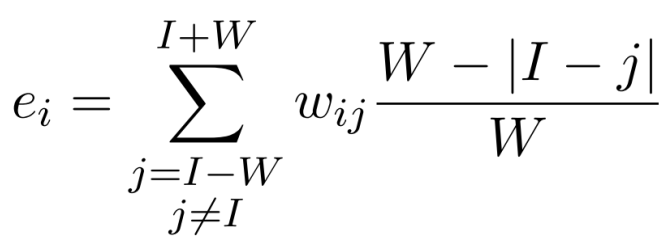

In [59]:
def get_context_vector(context, target_word, target_pos, vector_dimensions=300, model=model_skipgram):
    """
    context - raw text,
    target_word - слово, с которым мы работаем, например, 'дисциплина'. 
    """
    words_list_with_pos = preprocess(context)
    try:
        target_index = words_list_with_pos.index(target_word + "_" + target_pos)
    except ValueError:
        raise ValueError("В контексте нет целевого слова: ", context)
        
    left_words_vectors = []
    right_words_vectors = []
    non_zero_vectors_num = 0

    for i, word in enumerate(words_list_with_pos):
        if (word in model):
            non_zero_vectors_num += 1
            if i < target_index:
                left_words_vectors.append(model[word.replace("ё", "е")])
            elif i > target_index:
                right_words_vectors.append(model[word.replace("ё", "е")])
        else: 
            if i < target_index:
                left_words_vectors.append(np.zeros(vector_dimensions))
            elif i > target_index:
                right_words_vectors.append(np.zeros(vector_dimensions))
    
    if non_zero_vectors_num == 0:
        raise ValueError("В контексте нет ненулевых векторов: ", context)
    
    context_vector = np.zeros(vector_dimensions)
    # fractional decay weighting
    left_window_len = len(left_words_vectors)
    left_window_weights = [j / left_window_len for j in range(1, left_window_len + 1)] # веса
    right_window_len = len(right_words_vectors)
    rigth_window_weights = [j / right_window_len for j in range(right_window_len, 0, -1)]
    for i in range(vector_dimensions):
        for j, vector in enumerate(left_words_vectors): # for the left part
            context_vector[i] += vector[i] * left_window_weights[j]
        for j, vector in enumerate(right_words_vectors): # for the right part
            context_vector[i] += vector[i] * rigth_window_weights[j] 
                
    # нормализация: после того как получили вектор контекста, делим все его числа на количество непустых векторов:
    for i, digit in enumerate(context_vector):
        context_vector[i] = digit/(non_zero_vectors_num)
    return(context_vector.reshape(1, vector_dimensions))

In [150]:
vec = get_context_vector(input_str, "дисциплина", "NOUN")

### Находим лучший кластер

Полученный общий вектор контекста по косинусной мере сравнивается с векторами ключевых слов каждого из потенциальных кластеров, и выбирается один с самым высоким значением;
алгоритм выдаёт словарное определение, ранее выбранное для этого кластера.

In [72]:
# словарь с ключевыми словами для каждого кластера (инстансы GoodWord(self, lemma, pos_word, vec, cosine))
words_for_perfect

{'балка_NOUN': {1: [поперечный,
   крыша,
   потолочный,
   верёвка,
   труба,
   деревянный,
   колонна,
   стена,
   потолок,
   задний,
   висеть],
  2: [склон,
   станица,
   гора,
   степь,
   кустарник,
   камень,
   спускаться,
   сухой,
   берег,
   леса]},
 'вид_NOUN': {1: [сторона, глаз, придавать, следующий],
  5: [человек,
   место,
   свойственный,
   сказать,
   большой,
   дух,
   отличаться,
   результат]},
 'винт_NOUN': {1: [болт,
   гайка,
   пружина,
   регулировочный,
   ручка,
   крепление,
   отверстие,
   крышка,
   крепиться,
   головка,
   панель,
   регулировка,
   диаметр,
   резьба,
   конструкция,
   деталь],
  2: [лопасть,
   мотор,
   двигатель,
   несущий,
   вращение,
   гребной,
   вращаться,
   диаметр,
   самолёт,
   вертолёт,
   корабль,
   лодка,
   машина,
   скорость,
   вода,
   мощность,
   воздух,
   полёт]},
 'горн_NOUN': {1: [наковальня,
   кузница,
   пламя,
   кузнечный,
   чугун,
   уголь,
   кузня,
   огонь,
   печь,
   сталь,
   гудеть,

In [119]:
# словарь с определениями
df_best_cosine.head()

,target_word,sense_num,key_words,lemma,sense_name,definition
0,балка,1,поперечный крыша потолочный верёвка труба дере...,балка,I ж.,"Брус, укрепленный горизонтально между двумя ст..."
1,балка,2,склон станица гора степь кустарник камень спус...,балка,II ж.,"Длинный и широкий овраг, лощина (обычно с поло..."
2,вид,1,сторона глаз придавать следующий,вид,I м.,"2. То, что оказывается перед глазами, в поле з..."
3,вид,5,человек место свойственный сказать большой дух...,вид,I м.,"2. То, что оказывается перед глазами, в поле з..."
4,винт,1,болт гайка пружина регулировочный ручка крепле...,винт,I м.,"1. Стержень со спиральной нарезкой, служащий д..."


In [107]:
target_word = "дисциплина"
target_pos = "NOUN"
dict_for_target = words_for_perfect[target_word + "_" + target_pos]

In [79]:
dict_for_target

{1: [строгий, нарушение, вера, учебный],
 2: [преподавание,
  обучение,
  наука,
  учебный,
  преподаватель,
  специальность,
  студент,
  метод,
  курс,
  факультет]}

In [60]:
def disambiguate(context, target_word, target_pos, key_words_dict, definitions_for_clasters):
    """
    Последний метод, принимающий на вход необработанную строку с контекстом целевого слова, само целевое слово, его часть речи,
    словарь с ключевыми словами для каждого кластера и словарь с выбранными ранее определениями для каждого кластера.
    """
    context_vec = get_context_vector(context, target_word, target_pos)
    dict_for_target = key_words_dict[target_word + "_" + target_pos]
    
    mean_vecs_for_key_words = []
    for sense_num in dict_for_target:
        array = [instance.vec for instance in dict_for_target[sense_num]]
        mean_vec = np.mean(array, axis=0) # средний вектор для ключевых слов по имеющимся векторам для каждого слова
        mean_vecs_for_key_words.append(mean_vec) # средние вектора для каждого из значений целевого слова
    
    cos_values = []
    for key_words_vec in mean_vecs_for_key_words:
        c = cos(context_vec, key_words_vec).tolist()[0][0]
        cos_values.append(c)

    max_ind = cos_values.index(max(cos_values))
    result = definitions_for_clasters[definitions_for_clasters.
                                      target_word==target_word][definitions_for_clasters.
                                                                sense_num==str(max_ind+1)]["definition"]
    return result.values[0]

### Пример

In [61]:
input_str = "За очень редким исключением, люди не становятся богатыми быстро. Гораздо чаще за успехом стоит упорный труд, и дисциплина в нем играет важную роль"

In [63]:
disambiguate(input_str, "дисциплина", "NOUN", words_for_perfect, df_best_cosine)

C:\Users\boss\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


'2. разг. Строгое следование своим собственным правилам; самодисциплина.'